# NBA Analysis
#### Wenfei Yan, wenfeiy@andrew.cmu.edu
#### Mengqiu Teng, mengqiut@andrew.cmu.edu

NBA (National Basketball Association), the most popular basketball league in the world, has been founded for more than 70 years. Starting with 11 teams in 1946, the league has growed to 30 teams in 2004 and kept the size till now. Today's NBA games are very different from early games in many aspects. The league didn't have 3-points until 1979. There was no defensive 3-second violation until 2001. Hand-checking is no longer allowed from 2004. The league has changed a lot, and is keep evolving.

As data enthusiasts, we are naturally curious if any interesting change or trend could be reflected by DATA. Actually sport analytics has become a critical part of NBA. Now nearly every team (if not all) has a data analytics team to support the coaches and to make the team stronger. There are incredible rich data for NBA games, from box-scores to tracking data.

Considering accessibility of data, aggregated statistics by game and by player are available in several websites, and play-by-play data can be retrieved by a few APIs, while tracking data are not freely and publicly available. As aggregated level stats are already rich enough to investigate for trends or patterns,  we choose to conduct analysis with the box-scores and some advanced stats based on box-scores. The dataset we will use contains player stats from 1950, which will be described more detailedly in later sections.

## Project Goal and Proposed Approach

To further understand the dataset, we will first do some exploratory analysis and produce visualizations to answer a few quick questions. For example, are players playing less than before? Load management has recently become a buzz word and raised hot discussion. Some famous previous NBA players said there were not load balacing in the past.

For more in-depth analysis, we plan to investigate the change of player types in NBA. The classic 5-position category is no longer very expressive for the function or characteristic of modern NBA players. For example, traditional point guards focus less on scoring, while Stephen Curry, arguably the best current point guard in NBA, is incredibly good at both scoring and helping his teammates to score. The boundary between the 5 positions has become vague in modern NBA games. To this end, we have the following research questions. 
* Are there more fine-grained player types in modern NBA? Or do the players become more positionless (i.e. more similar across positions)?
* If there are more fine-grained player types, how are these types evovling in different eras of NBA?

We propose to address the research questions by network analysis.  We will first define a similarity metric using the player stats, and construct a similarity network of players. Then we will perform community detection on the network to identify different groups of players. We will also construct networks with data from different time periods, and compare the results to how the player types evolve.

## Dataset Overview

This dataset contains aggregate individual statistics for each NBA player. It covers a wide range of period from 1950 to 2017 including 67 NBA seasons. The detailed information includes year, player name, team, games played, minutes played, total points, true shooting percentage and etc. A detailed description of the data can also be found at https://www.basketball-reference.com/about/glossary.html.

The dataset is directly obatined from Kaggle page https://www.kaggle.com/drgilermo/nba-players-stats#Seasons_Stats.csv. The author of Kaggle project scrapped data from https://www.basketball-reference.com/, which is the original source of data.

Time permitting, we will later scrap the 2017-2019 seasons ourselves, in order to make the dataset as well as our analysis more complete. For part 1, we will only use the Kaggle dataset.

## Data Quality Assessment with 4 "C"s

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
# Get Data From GitHub
url = "https://raw.githubusercontent.com/mengqiuteng/ids-final/master/data/seasons_stats.csv"
df = pd.read_csv(url)
df = df.rename(columns= {"Unnamed: 0": "index"}).set_index("index")
# Drop blank rows and columns
df = df.dropna(axis=0, how="all")
df = df.drop(columns=["blanl", "blank2"])

### Completeness
The data is realtively complete. The original csv file comes with two columns that were completely empty and has no value at all ("blan1", "blank2" columns) and hence we deleted these two columns for all records. Furthermore, the original csv comes with some extra empty rows and we dropped those empty rows as well. After this simple cleaning, the data was pretty complete. 

Before 1985, some player statistics were not recorded (e.g., TOV turnovers) thus leaving empty blanks in some columns. 
It has record since 1950 with player name, position, team and age. Since 1985, over 80% of the rows are complete, and most of the empty blanks belong to palyers with no enough playing minutes. 

Later in the anlaysis of the data, we will further drop certain records to address different concerns. For example, since the number of games in each regular season was not 82 before 1967, we will drop games before 1967 in the minutes played analysis for consistency. Also, some edge players have very few records, when anlyzing the style of each player, we will eliminate players with too few minutes played to reduce variance in data.

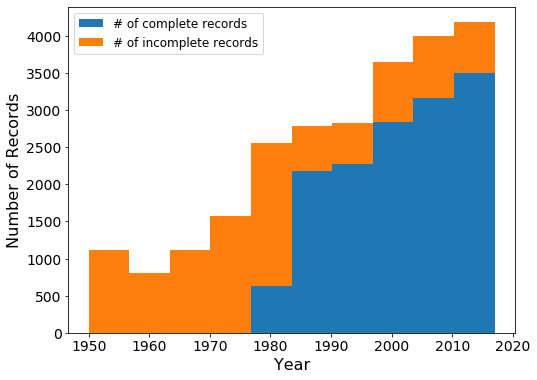

In [0]:
df['complete'] = ~df.isna().any(axis=1)
s_complete = df[df["complete"]]["Year"]
s_incomplete = df[~df["complete"]]["Year"]
plt.figure(figsize=(8, 6))
plt.hist([s_complete, s_incomplete], stacked=True, bins=10)
plt.ylabel("Number of Records", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.tick_params(labelsize=14)
# plt.title('Number of complete and incomplete records in dataset for different years.', fontdict = {'fontsize' : 20})
plt.legend(["# of complete records", "# of incomplete records"], prop={'size': 12})
plt.show()

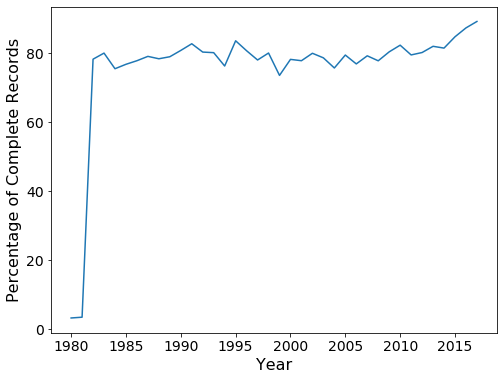

In [0]:
count_complete = df[(df["complete"] == True) & (df["Year"] >= 1980)].groupby("Year").count()["Player"]
count_incomplete = df[(df["complete"] == False) & (df["Year"] >= 1980)].groupby("Year").count()["Player"]
complete_portion = count_complete / (count_incomplete + count_complete) * 100
plt.figure(figsize=(8, 6))
plt.plot(complete_portion.index, complete_portion)
plt.ylabel("Percentage of Complete Records", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.tick_params(labelsize=14)
plt.show()

### Coherency
Generally the data is coherent. The years are all integers and all lie in the range of 1950 to 2017. Values for percentage information for different fields all lie in the range of 0 to 1. The minutes played by each player in a season are all smaller than 3936 (= 82 * 48), which is maximum possible minutes played for a sesaon. For the vast majority of players, their number of games played in a season is smaller of euqal to 82. However, there do exist around 40 players (e.g. Josh Smith in 14-15 season) who were able to play more than 82 games in a season. After careful checking, we found these are players who were traded and who played games for different teams in the same season. This made it possible for them to indeed play more than 82 games.

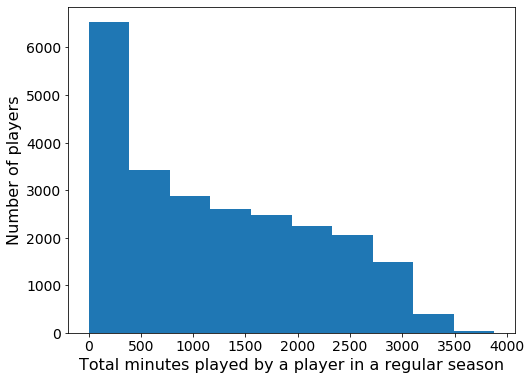

In [0]:
plt.figure(figsize=(8, 6))
plt.ylabel("Number of players", fontsize=16)
plt.xlabel("Total minutes played by a player in a regular season", fontsize=16)
plt.tick_params(labelsize=14)
df["MP"].hist(grid=False)

In [0]:
df["MP"].max()

3882.0

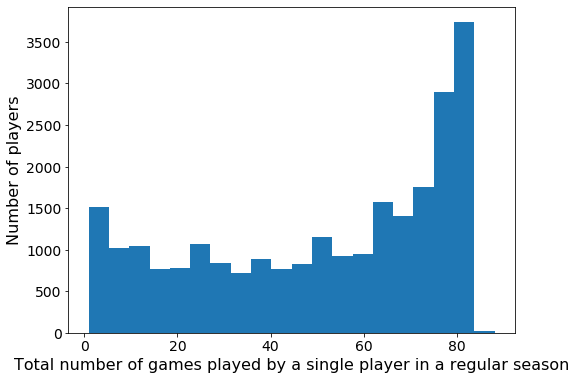

In [0]:
plt.figure(figsize=(8, 6))
plt.ylabel("Number of players", fontsize=16)
plt.xlabel("Total number of games played by a single player in a regular season", fontsize=16)
plt.tick_params(labelsize=14)
df["G"].hist(bins=20, grid=False)

In [0]:
df[df["G"] > 82].head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2632,1968.0,John Tresvant,PF,28.0,TOT,85.0,NaN,2473.0,13.2,0.503,NaN,0.443,NaN,NaN,NaN,8.3,NaN,NaN,NaN,NaN,2.4,1.7,4.1,0.079,NaN,NaN,NaN,NaN,396.0,867.0,0.457,NaN,NaN,NaN,396.0,867.0,0.457,0.457,250.0,384.0,0.651,NaN,NaN,709.0,160.0,NaN,NaN,NaN,344.0,1042.0
2676,1969.0,Walt Bellamy*,C,29.0,TOT,88.0,NaN,3159.0,18.0,0.555,NaN,0.560,NaN,NaN,NaN,7.6,NaN,NaN,NaN,NaN,7.7,2.6,10.4,0.157,NaN,NaN,NaN,NaN,563.0,1103.0,0.510,NaN,NaN,NaN,563.0,1103.0,0.510,0.510,401.0,618.0,0.649,NaN,NaN,1101.0,176.0,NaN,NaN,NaN,320.0,1527.0
2741,1969.0,Fred Hetzel,SF,26.0,TOT,84.0,NaN,2276.0,15.6,0.503,NaN,0.341,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,3.2,1.3,4.5,0.095,NaN,NaN,NaN,NaN,456.0,1047.0,0.436,NaN,NaN,NaN,456.0,1047.0,0.436,0.436,299.0,357.0,0.838,NaN,NaN,613.0,112.0,NaN,NaN,NaN,287.0,1211.0
2762,1969.0,Howard Komives,PG,27.0,TOT,85.0,NaN,2562.0,11.5,0.444,NaN,0.271,NaN,NaN,NaN,20.6,NaN,NaN,NaN,NaN,-0.2,1.6,1.4,0.026,NaN,NaN,NaN,NaN,379.0,974.0,0.389,NaN,NaN,NaN,379.0,974.0,0.389,0.389,211.0,264.0,0.799,NaN,NaN,299.0,403.0,NaN,NaN,NaN,274.0,969.0
2814,1969.0,Flynn Robinson,PG,27.0,TOT,83.0,NaN,2616.0,18.6,0.501,NaN,0.340,NaN,NaN,NaN,22.1,NaN,NaN,NaN,NaN,4.7,2.0,6.7,0.123,NaN,NaN,NaN,NaN,625.0,1442.0,0.433,NaN,NaN,NaN,625.0,1442.0,0.433,0.433,412.0,491.0,0.839,NaN,NaN,306.0,377.0,NaN,NaN,NaN,261.0,1662.0


### Correctness
The data has relatively high correctness. We manually sampled some records from the Kaggle data and checked them with the records on original website. All information for those records matched up. 
Furthermore, we made another sample of the records, and check it with the stats.nba.com, which is the official stats site of NBA, aiming to check the correctness of data on basketball-reference.com. The basic stats, such as PTS (points), all matched. Some advanced stats (e.g., USG% usage percentage) are different but close, since different formulas are used on the two websites. Also, the reputation and wide usage of the the site basketball-reference among sports analytics people add to the credebility of the data.

### Accountability
The original data come from a reliable website that received high comments from media like New York Times and professional NBA television analyst like Jim Petersen. The data is publicly available online for all people to check and verify. All the modifications we make to the original data were carefully recorded. Before making claims on the data, we also cross-verified information from other sources to make sure the claimes are backed up.

## Data Exploratory Analysis

Since the starting date of record is different for different types of information, and some game rules have changed since 1950 while others reminaed the same, we peformed different forms of cleaning for different types of information instead of performing a unified general cleaning. Hence, for the following parts, we will first start each section with a question we would like to answer, how we cleaned data correspondingly and then demonstrate the results.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
df.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,NaN,0.467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1,3.6,3.5,NaN,NaN,NaN,NaN,NaN,144.0,516.0,0.279,NaN,NaN,NaN,144.0,516.0,0.279,0.279,170.0,241.0,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,NaN,0.387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,0.6,2.2,NaN,NaN,NaN,NaN,NaN,102.0,274.0,0.372,NaN,NaN,NaN,102.0,274.0,0.372,0.372,75.0,106.0,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,NaN,0.259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,2.8,3.6,NaN,NaN,NaN,NaN,NaN,174.0,499.0,0.349,NaN,NaN,NaN,174.0,499.0,0.349,0.349,90.0,129.0,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,NaN,0.395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,22.0,86.0,0.256,NaN,NaN,NaN,22.0,86.0,0.256,0.256,19.0,34.0,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,NaN,0.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.1,-0.6,NaN,NaN,NaN,NaN,NaN,21.0,82.0,0.256,NaN,NaN,NaN,21.0,82.0,0.256,0.256,17.0,31.0,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


### Are the games becoming more offensive?
Many rule changes in NBA are said to encourage offense so that the game will be more fun to watch, such as the ban of hand-checking. So are the games become more offensive? We plot a line chart of the average points of a game versus year to illustratet the trend. The plot starts from 1967-1968 season, as since then the regular NBA seanson started to have 82 games.

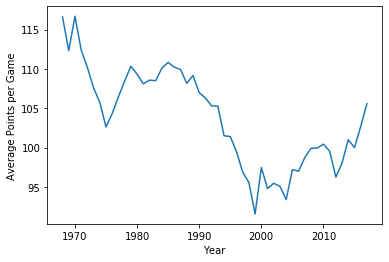

In [0]:
off = df[df['Year'] > 1967].copy()
off = off[off['Tm']!='TOT'].copy()  # TOT is not a team, but means TOTAL for players traded during a season
avg_score_team = off[['Year', 'Tm', 'PTS']].groupby(['Year', 'Tm']).sum().reset_index()
lockout_games = {1999: 50, 2012: 66}
avg_score_team['PTS/G'] = avg_score_team.apply(
    lambda row: row['PTS']/82 if row['Year'] not in lockout_games else row['PTS']/lockout_games[row['Year']], 
    axis=1)  # lock out seasons
avg_score = avg_score_team.groupby('Year')['PTS/G'].mean().reset_index()
plt.plot(avg_score['Year'], avg_score['PTS/G'])
plt.xlabel('Year')
plt.ylabel('Average Points per Game')
plt.show()

In [0]:
avg_df = pd.DataFrame()
avg_df['Year'] = avg_score['Year']
avg_df['PTS/G'] = avg_score['PTS/G']
avg_df.to_csv("avg_points_pergame_perteam.csv")

We find generally two drasctic drop in mid 1970s and in the 1990s, and then an increasing trend till 2017. The recent increasing trend agrees with the recent discussion of scoring explosion. The drop in 1990s might have something to do with the league expansion, so many "worse" players entered the league, and affected the "quality" of the game. It was also said the iso-ball have made offense harder.

### Are players playing less than before?

In [0]:
!pip install joypy
import joypy

How does the distribution of the minutes a player played per game change over time? Is it true that players tend to play shorter time in a single game nowadays due to the rising focus on physicial mangement? To answer this question, we made a joyplot with the average minutes a player played in a game. Again, for simplicity and consistency, records before 1967-1968 season are dropped, as only since then the regular NBA seanson started to have 82 games. Also, we exclude players with minutes played smaller than 100 in a season.

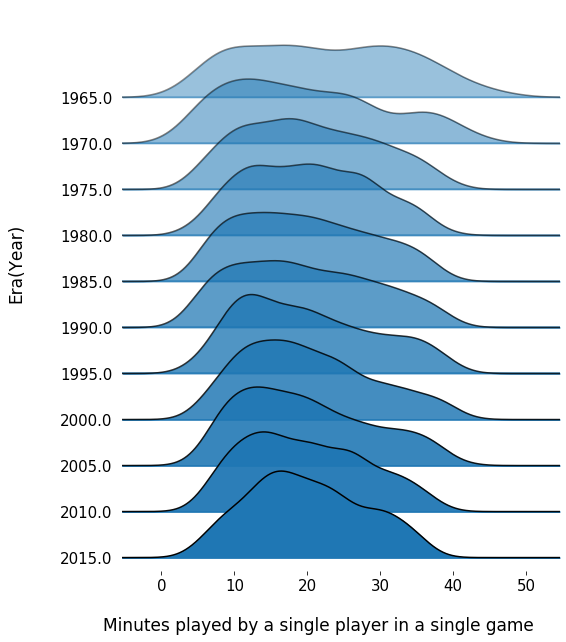

In [0]:
play_time = df[df['Year'] > 1967].copy()
play_time = play_time[play_time['MP'] >= 100].copy()
play_time["Era"] = play_time["Year"] // 5 * 5
play_time = play_time[['Era','Player','G', 'MP']].groupby(['Era', 'Player']).sum().reset_index()
play_time['MP/G'] = play_time['MP'] / play_time['G']
fig, axes = joypy.joyplot(play_time, by='Era', column='MP/G', overlap=1.2, fade=True, figsize=(10 * 0.7, 12 * 0.7))
for ax in axes:
    ax.tick_params(labelsize=15)
# plt.title("Minutes played by a single player in a single game for different eras", fontsize=)
fig.text(0.5, -0.05, "Minutes played by a single player in a single game", ha='center', fontsize=17)
fig.text(-0.1, 0.5, "Era(Year)", ha='center', fontsize=17, rotation='vertical')
fig.savefig("minutesplayedjoy.png", format="png")
plt.show()

As shown in the plot, the distribution of playing time becomes more and more concentrate. In other words, fewer players have extreme average minutes played (i.e., more than 40 mins). On the other hand, the bench players have higher playing time, as they are making up of the time left by the top players. So, the observation can be interpreted as that top players are playing a little bit fewer so as to better protect themselves.